# 模型选择、欠拟合和过拟合

通过多项式拟合来交互地探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用以下三阶多项式来生成训练和测试数据的标签：
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

看一下前2个样本

In [4]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.9773],
         [-0.3667]]),
 tensor([[ 1.0000e+00, -1.9773e+00,  1.9549e+00, -1.2885e+00,  6.3692e-01,
          -2.5188e-01,  8.3006e-02, -2.3447e-02,  5.7952e-03, -1.2732e-03,
           2.5175e-04, -4.5254e-05,  7.4567e-06, -1.1342e-06,  1.6019e-07,
          -2.1116e-08,  2.6095e-09, -3.0352e-10,  3.3342e-11, -3.4698e-12],
         [ 1.0000e+00, -3.6667e-01,  6.7222e-02, -8.2161e-03,  7.5314e-04,
          -5.5231e-05,  3.3752e-06, -1.7680e-07,  8.1032e-09, -3.3013e-10,
           1.2105e-11, -4.0350e-13,  1.2329e-14, -3.4774e-16,  9.1076e-18,
          -2.2263e-19,  5.1019e-21, -1.1004e-22,  2.2416e-24, -4.3259e-26]]),
 tensor([-11.3695,   4.2423]))

实现一个函数来评估模型在给定数据集上的损失

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正态)

weight: [[ 5.009437   1.1840527 -3.417101   5.6196923]]


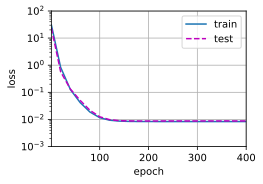

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[2.9549925 4.678829 ]]


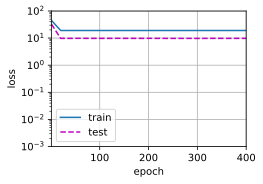

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 5.0257826e+00  1.2773601e+00 -3.4632597e+00  5.2138634e+00
   6.3908733e-02  9.7397679e-01  2.1160348e-01 -1.4446858e-01
   4.3702167e-02  8.6638503e-02  1.6130476e-01 -6.0289305e-02
   5.9521105e-02  1.9247933e-01  2.4845446e-03 -1.2461190e-01
  -1.3526279e-01 -1.8785698e-02 -2.1574648e-01 -1.5715948e-01]]


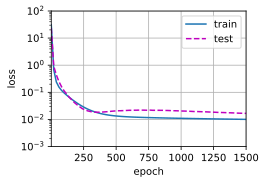

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)